In [1]:
import gc
import pathlib

import cugraph
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import scipy
from networkx.algorithms import approximation
from tqdm import tqdm

In [191]:
metrics_dir = pathlib.Path("../metrics")
datasets = ["small", "mid", "pace_weighted", "watts_strogatz"]

checkpoints = set(metrics_dir.rglob("*-checkpoint.csv"))
metrics_paths = list(
    sorted(
        set(
            chain.from_iterable(
                metrics_path.rglob(f"*{dataset}_metrics.csv") for dataset in datasets
            )
        )
        - checkpoints
    )
)

In [205]:
df = pd.read_csv(metrics_paths[0])
df

,Unnamed: 0,name,opt_weight,heuristic_weight,baseline_weight,local_search_weight,greedy_weight
0,0,erdos-reyni-n1000-p0.005--maxw2000-seed5_0.graph,NaN,479088,479088,492328,461997
1,1,erdos-reyni-n1000-p0.005--maxw2000-seed5_1.graph,506460.0,494202,494202,506460,474486
2,2,erdos-reyni-n1000-p0.005--maxw2000-seed5_10.graph,NaN,483733,483733,508220,474429
3,3,erdos-reyni-n1000-p0.005--maxw2000-seed5_100.g...,NaN,488720,488720,506865,466913
4,4,erdos-reyni-n1000-p0.005--maxw2000-seed5_1000....,NaN,450485,450485,495251,460759
...,...,...,...,...,...,...,...
4995,4995,erdos-reyni-n1000-p0.005--maxw2000-seed5_995.g...,NaN,473596,473596,499285,458146
4996,4996,erdos-reyni-n1000-p0.005--maxw2000-seed5_996.g...,NaN,480220,480220,502655,472583
4997,4997,erdos-reyni-n1000-p0.005--maxw2000-seed5_997.g...,NaN,496002,496002,515480,471632
4998,4998,erdos-reyni-n1000-p0.005--maxw2000-seed5_998.g...,NaN,490111,490111,501151,448268


In [216]:
def plot_ls_ratio(path, ax):
    df = pd.read_csv(path).dropna()

    values = [
        df.heuristic_weight / df.local_search_weight,
        df.baseline_weight / df.local_search_weight,
        df.greedy_weight / df.local_search_weight,
    ]
    names = ["WMVC", "BASELINE", "Greedy"]

    ax.boxplot(values)
    ax.set_xticklabels(names)

    ax.set_ylabel("Ratio")

    ax.set_title(path.stem)

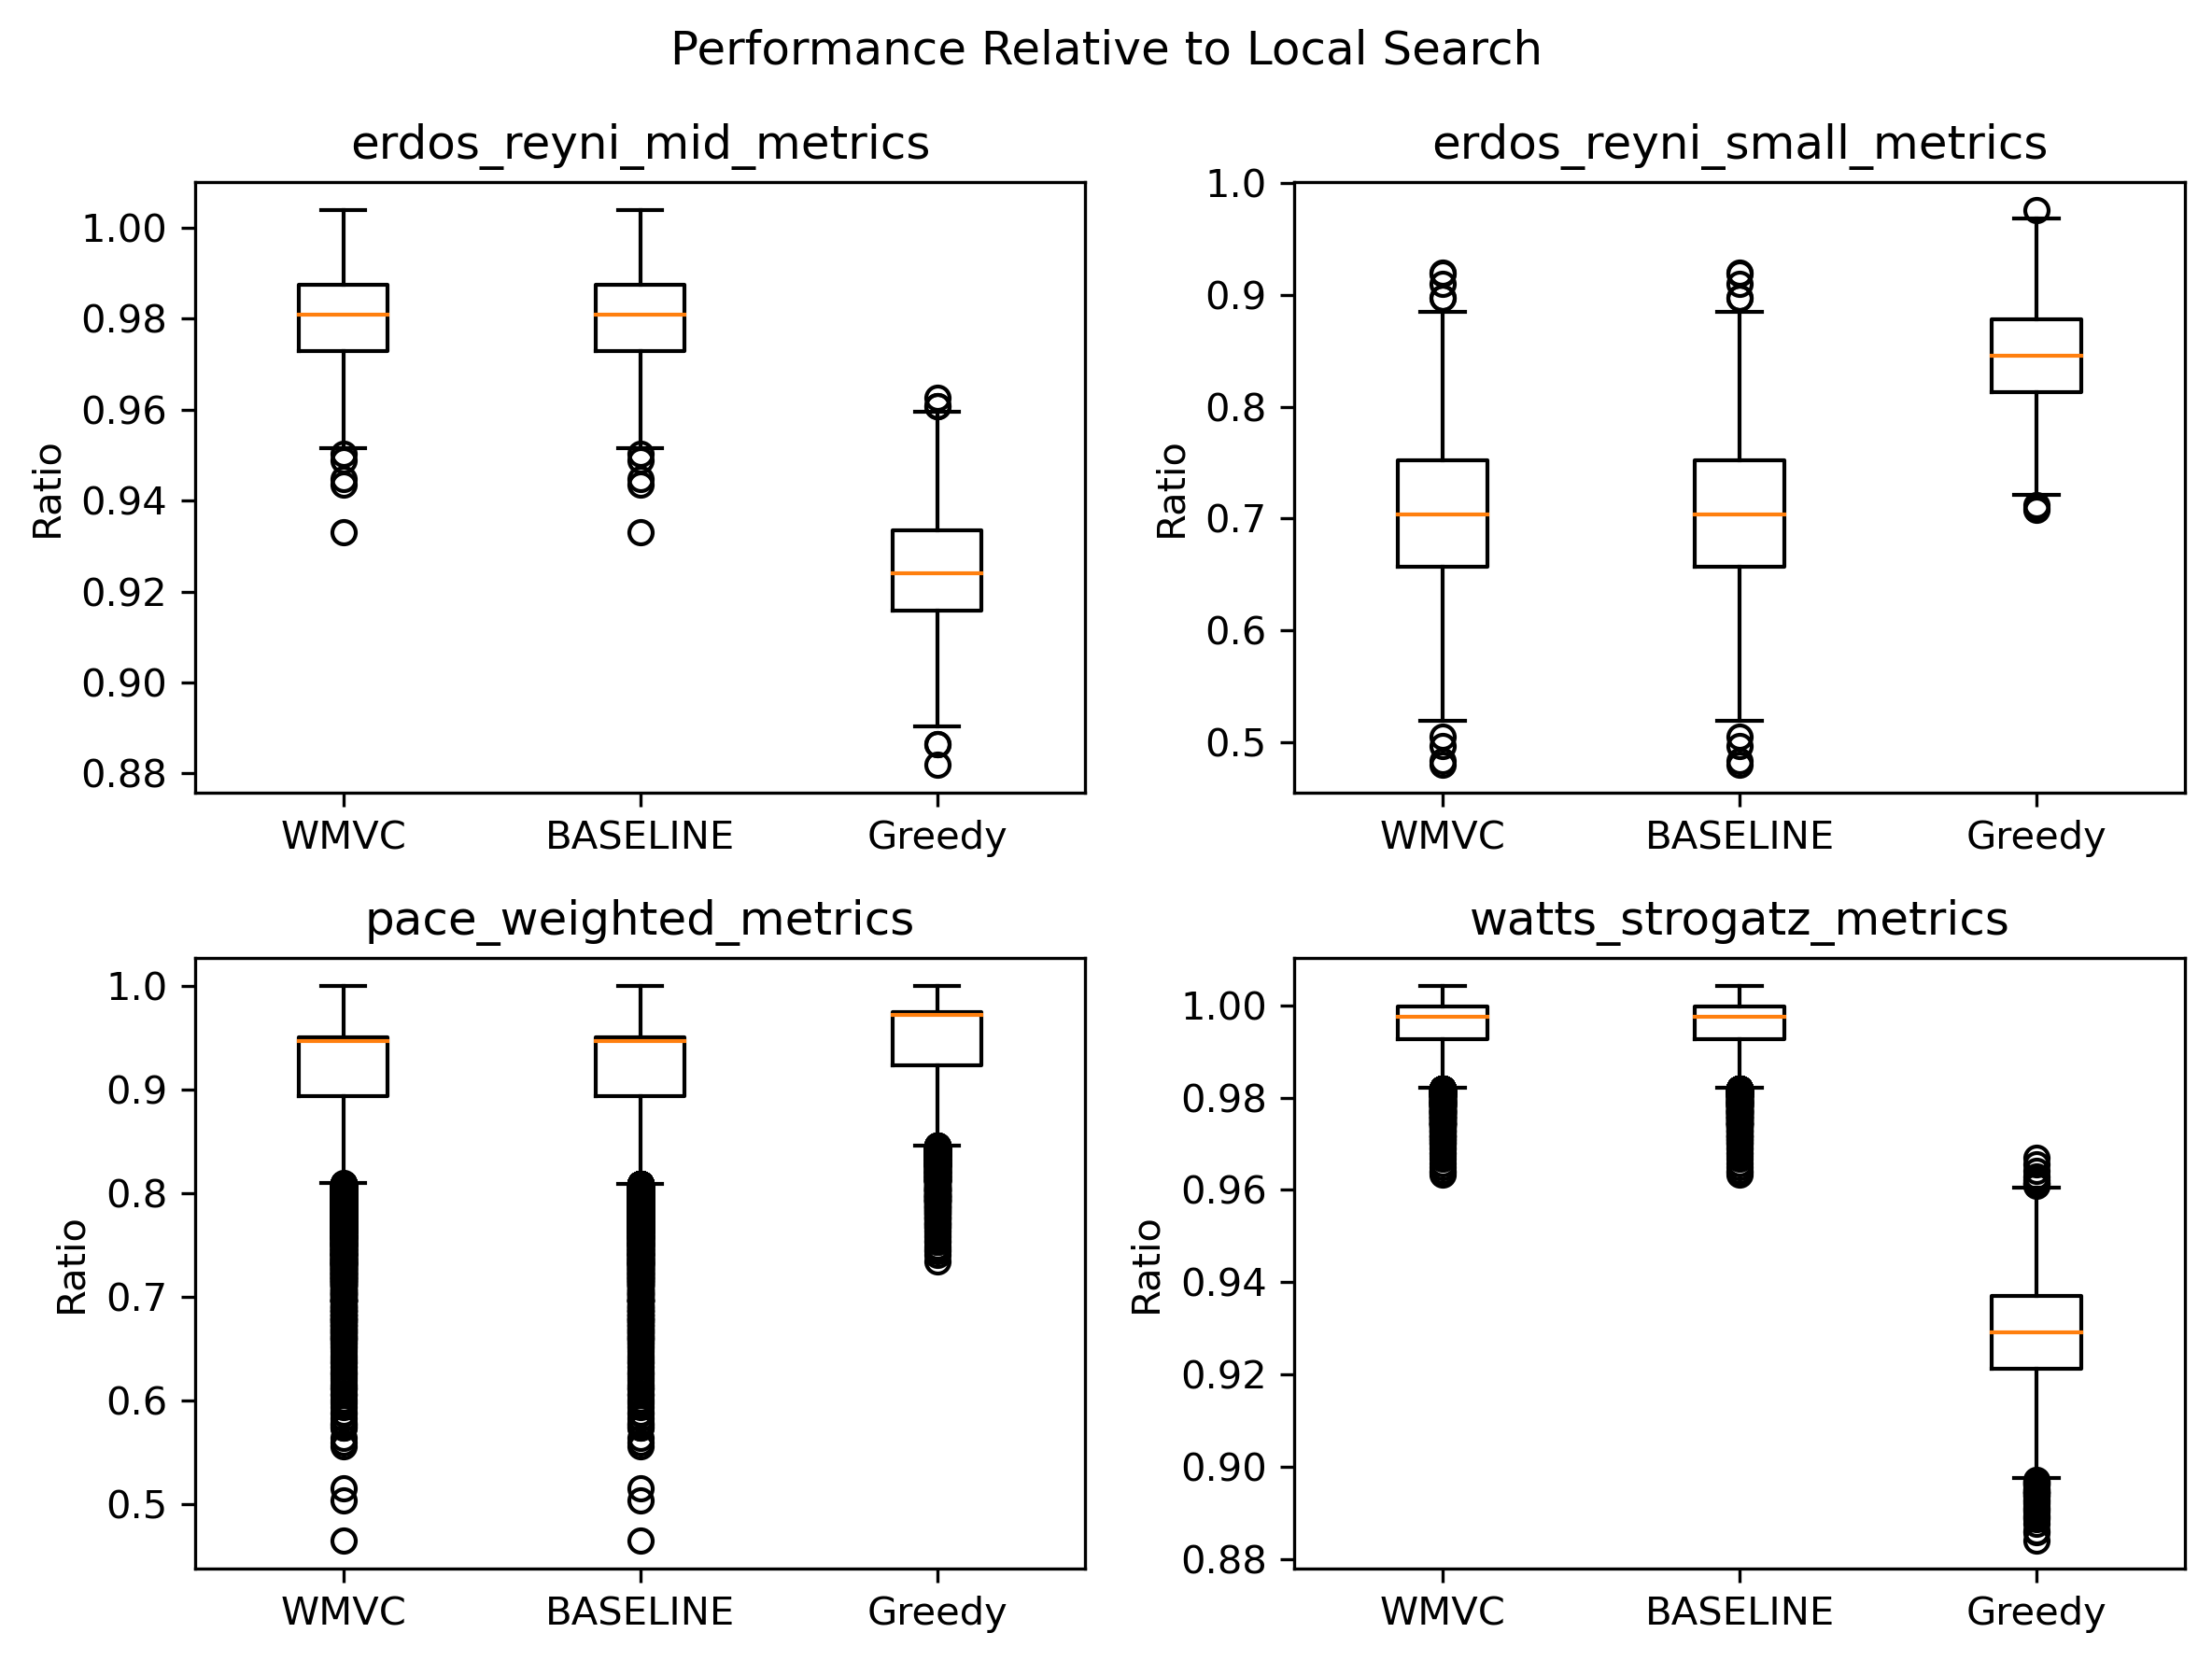

In [217]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

plot_ls_ratio(metrics_paths[0], axes[0, 0])
plot_ls_ratio(metrics_paths[1], axes[0, 1])
plot_ls_ratio(metrics_paths[2], axes[1, 0])
plot_ls_ratio(metrics_paths[3], axes[1, 1])

fig.set_dpi(300)
fig.suptitle("Performance Relative to Local Search")
fig.tight_layout()

fig.savefig("local_search.pdf")

In [211]:
def plot_approx_ratio(path, ax):
    df = pd.read_csv(path).dropna()

    values = [
        df.heuristic_weight / df.opt_weight,
        df.baseline_weight / df.opt_weight,
        df.local_search_weight / df.opt_weight,
        df.greedy_weight / df.opt_weight,
    ]
    names = ["WMVC", "BASELINE", "Local Search", "Greedy"]

    ax.boxplot(values)
    ax.set_xticklabels(names)

    ax.set_ylabel("Approximation Ratio")

    ax.set_title(path.stem)

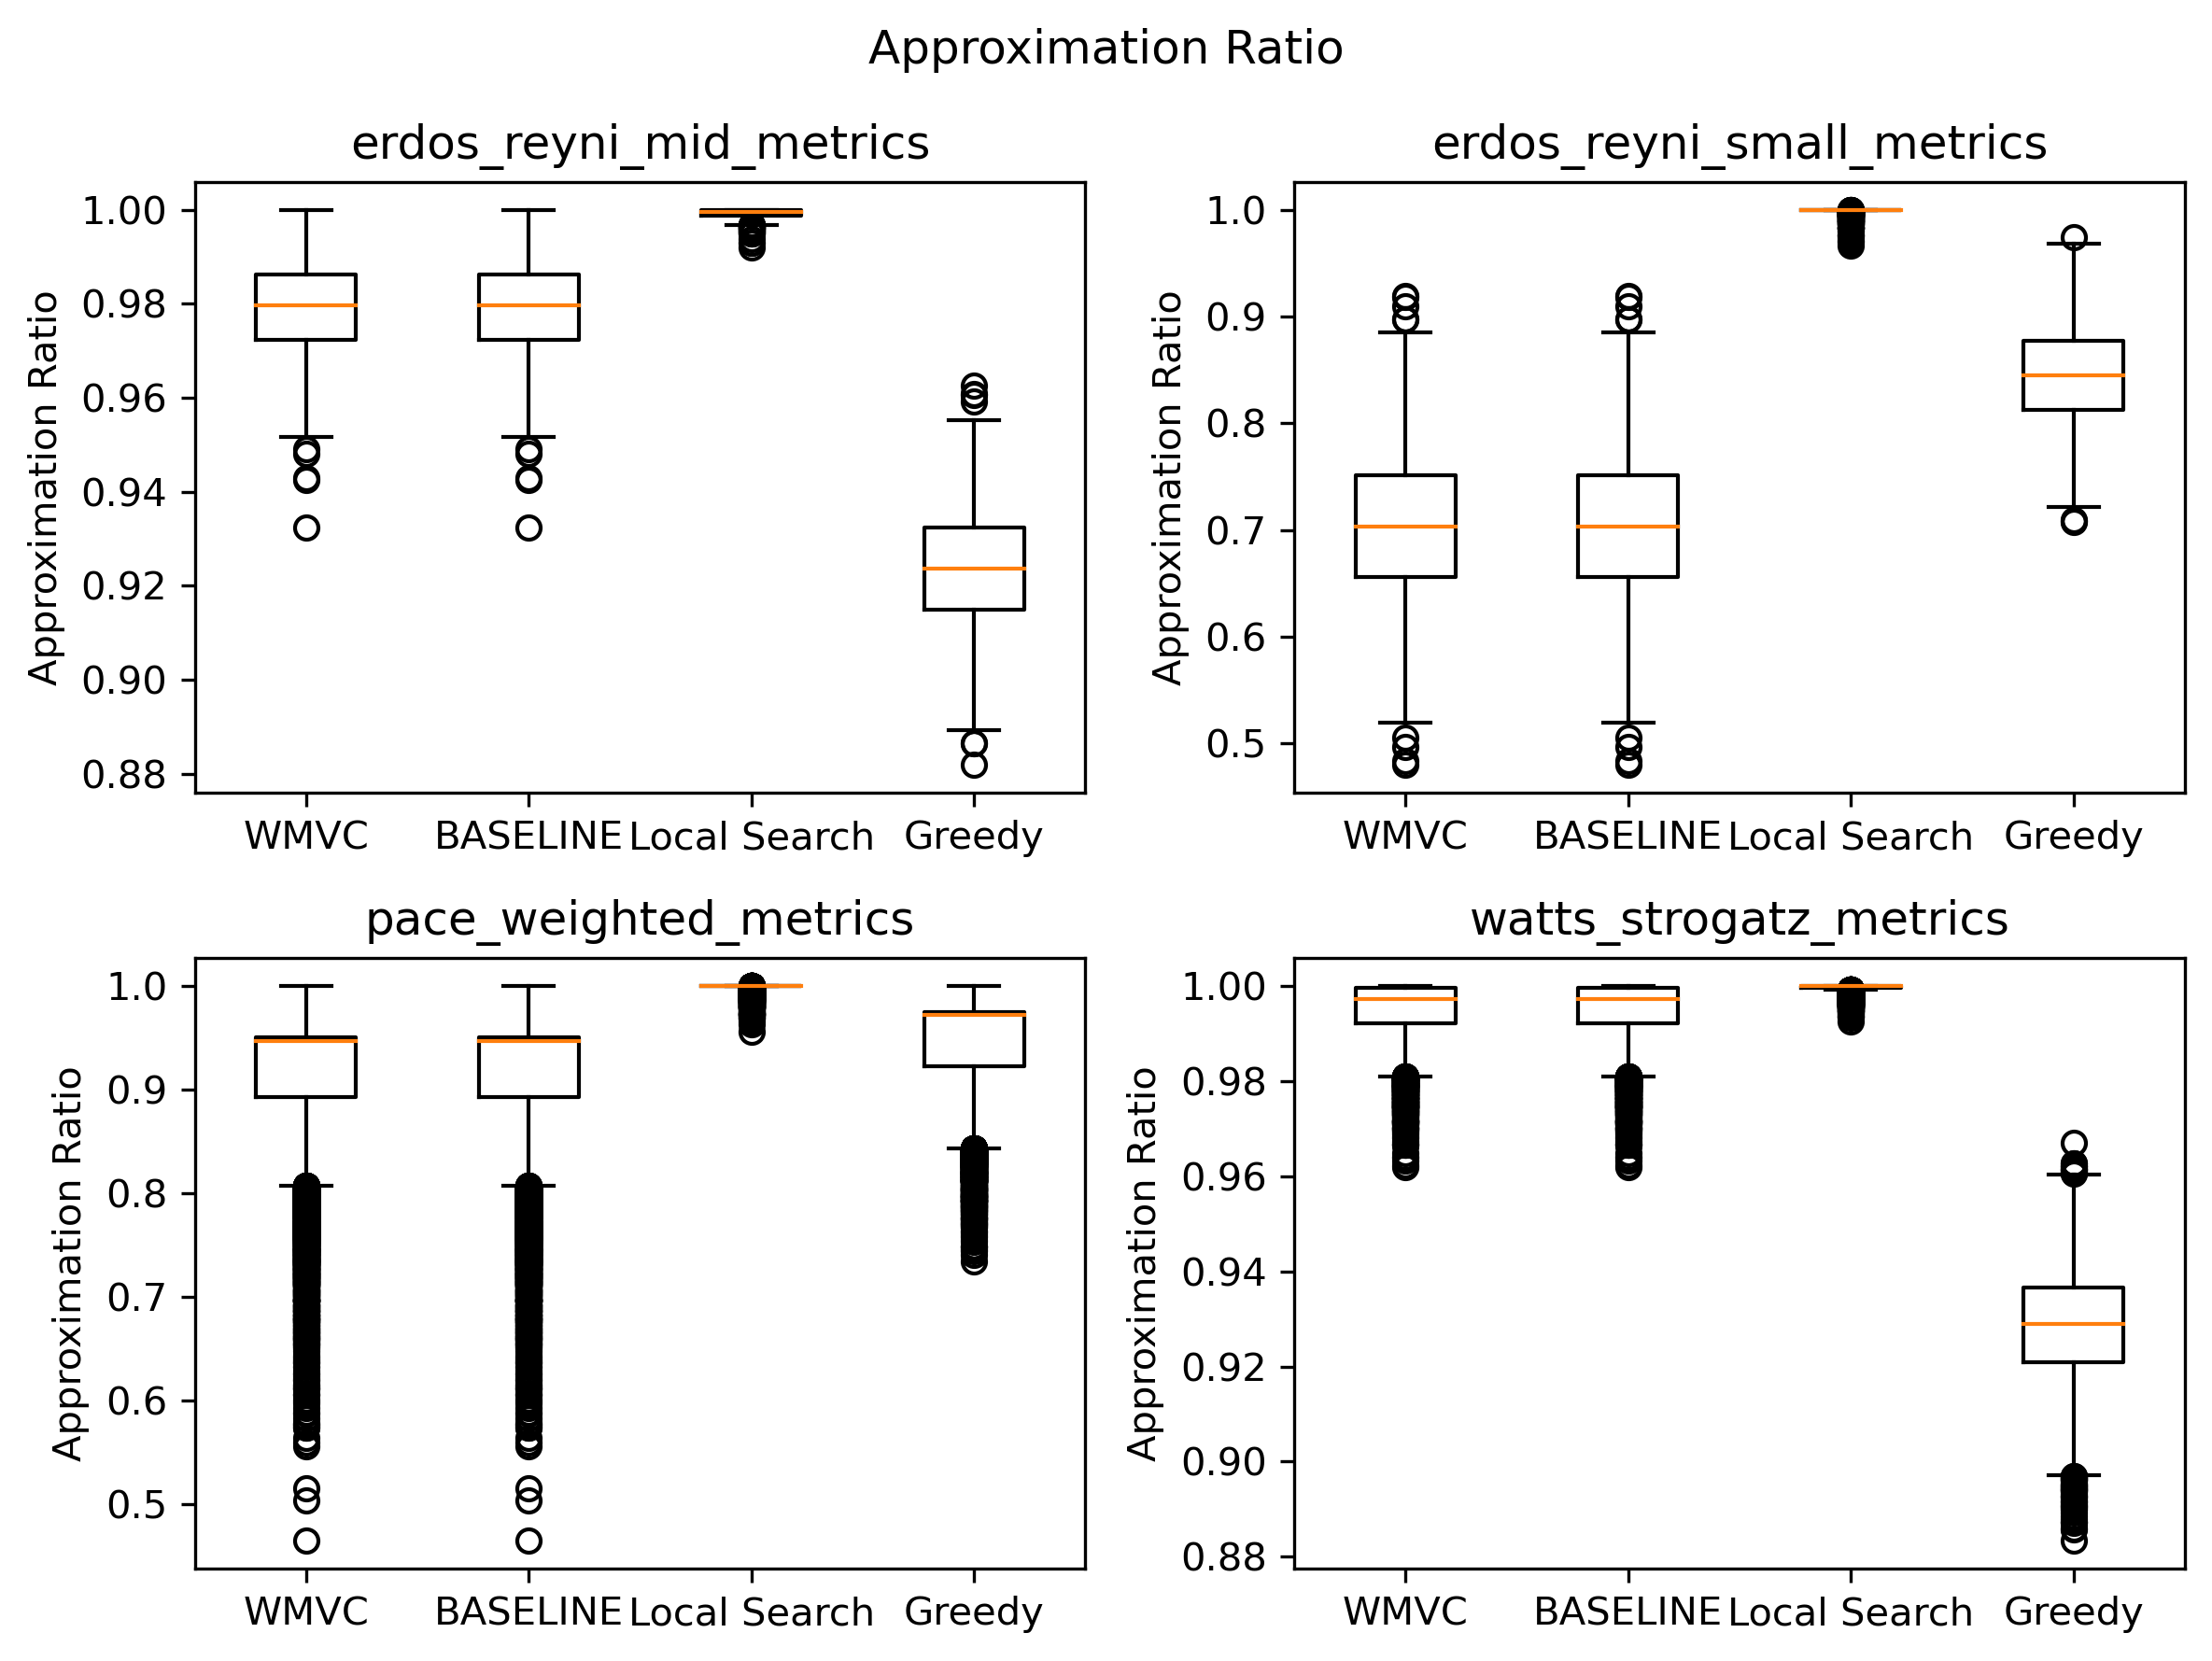

In [213]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

plot_approx_ratio(metrics_paths[0], axes[0, 0])
plot_approx_ratio(metrics_paths[1], axes[0, 1])
plot_approx_ratio(metrics_paths[2], axes[1, 0])
plot_approx_ratio(metrics_paths[3], axes[1, 1])

fig.set_dpi(300)
fig.suptitle("Performance Relative to Local Search")
fig.tight_layout()

fig.savefig("approx_ratio.pdf")

In [31]:
models_path = pathlib.Path("../models/")
datasets = ["er_small", "er_mid", "pace_weighted", "ws"]

In [35]:
from itertools import chain

checkpoints = set(models_path.rglob("*-checkpoint.csv"))

wmvc_eval = list(
    sorted(
        set(
            chain.from_iterable(
                models_path.rglob(f"wmvc_{dataset}*.csv") for dataset in datasets
            )
        )
        - checkpoints
    )
)
baseline_eval = list(
    sorted(
        set(
            chain.from_iterable(
                models_path.rglob(f"baseline_{dataset}*.csv") for dataset in datasets
            )
        )
        - checkpoints
    )
)

In [44]:
pd.read_csv(baseline_eval[0])

,train_loss,train_acc,train_acc_10,train_acc_1,eval_acc,eval_acc_10,eval_acc_1
0,0.708640,0.409211,0.932227,0.992188,0.408595,0.951899,0.974684
1,0.703733,0.416123,0.937305,1.000000,0.420342,0.950633,0.974684
2,0.695268,0.529045,0.939844,1.000000,0.577127,0.956962,0.987342
3,0.685644,0.671084,0.951172,1.000000,0.679696,0.958228,0.987342
4,0.675565,0.646908,0.949414,1.000000,0.635722,0.959494,0.987342
...,...,...,...,...,...,...,...
295,0.422372,0.835232,0.999805,1.000000,0.833747,1.000000,1.000000
296,0.419050,0.835297,0.999805,1.000000,0.833532,1.000000,1.000000
297,0.420020,0.835688,0.999805,1.000000,0.833937,1.000000,1.000000
298,0.419590,0.835752,0.999805,1.000000,0.834253,1.000000,1.000000


In [129]:
def plot_training(path, ax):
    df = pd.read_csv(path)

    ax.set_xlim([0, 151])
    ax.set_ylim([0, 1.1])

    ax.set_title(path.stem)
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Accuracy")

    # ax.plot(df.train_acc_10, "--", label="Training Accuracy 10")
    # ax.plot(df.train_acc_1, "--", label="Training Accuracy 1")

    ax.plot(df.eval_acc_1, label="Test Accuracy 1")
    ax.plot(df.eval_acc_10, label="Test Accuracy 10")
    ax.plot(df.eval_acc, label="Test Accuracy")

    ax.plot(df.train_acc, "--", label="Training Accuracy")

    ax.legend(loc="lower right")

In [133]:
def plot_training_all(paths, suptitle, filename):
    fig, axes = plt.subplots(2, 2, figsize=(8, 6))

    plot_training(paths[0], axes[0, 0])
    plot_training(paths[1], axes[0, 1])
    plot_training(paths[2], axes[1, 0])
    plot_training(paths[3], axes[1, 1])

    fig.set_dpi(300)
    fig.suptitle(suptitle)
    fig.tight_layout()

    fig.savefig(filename)

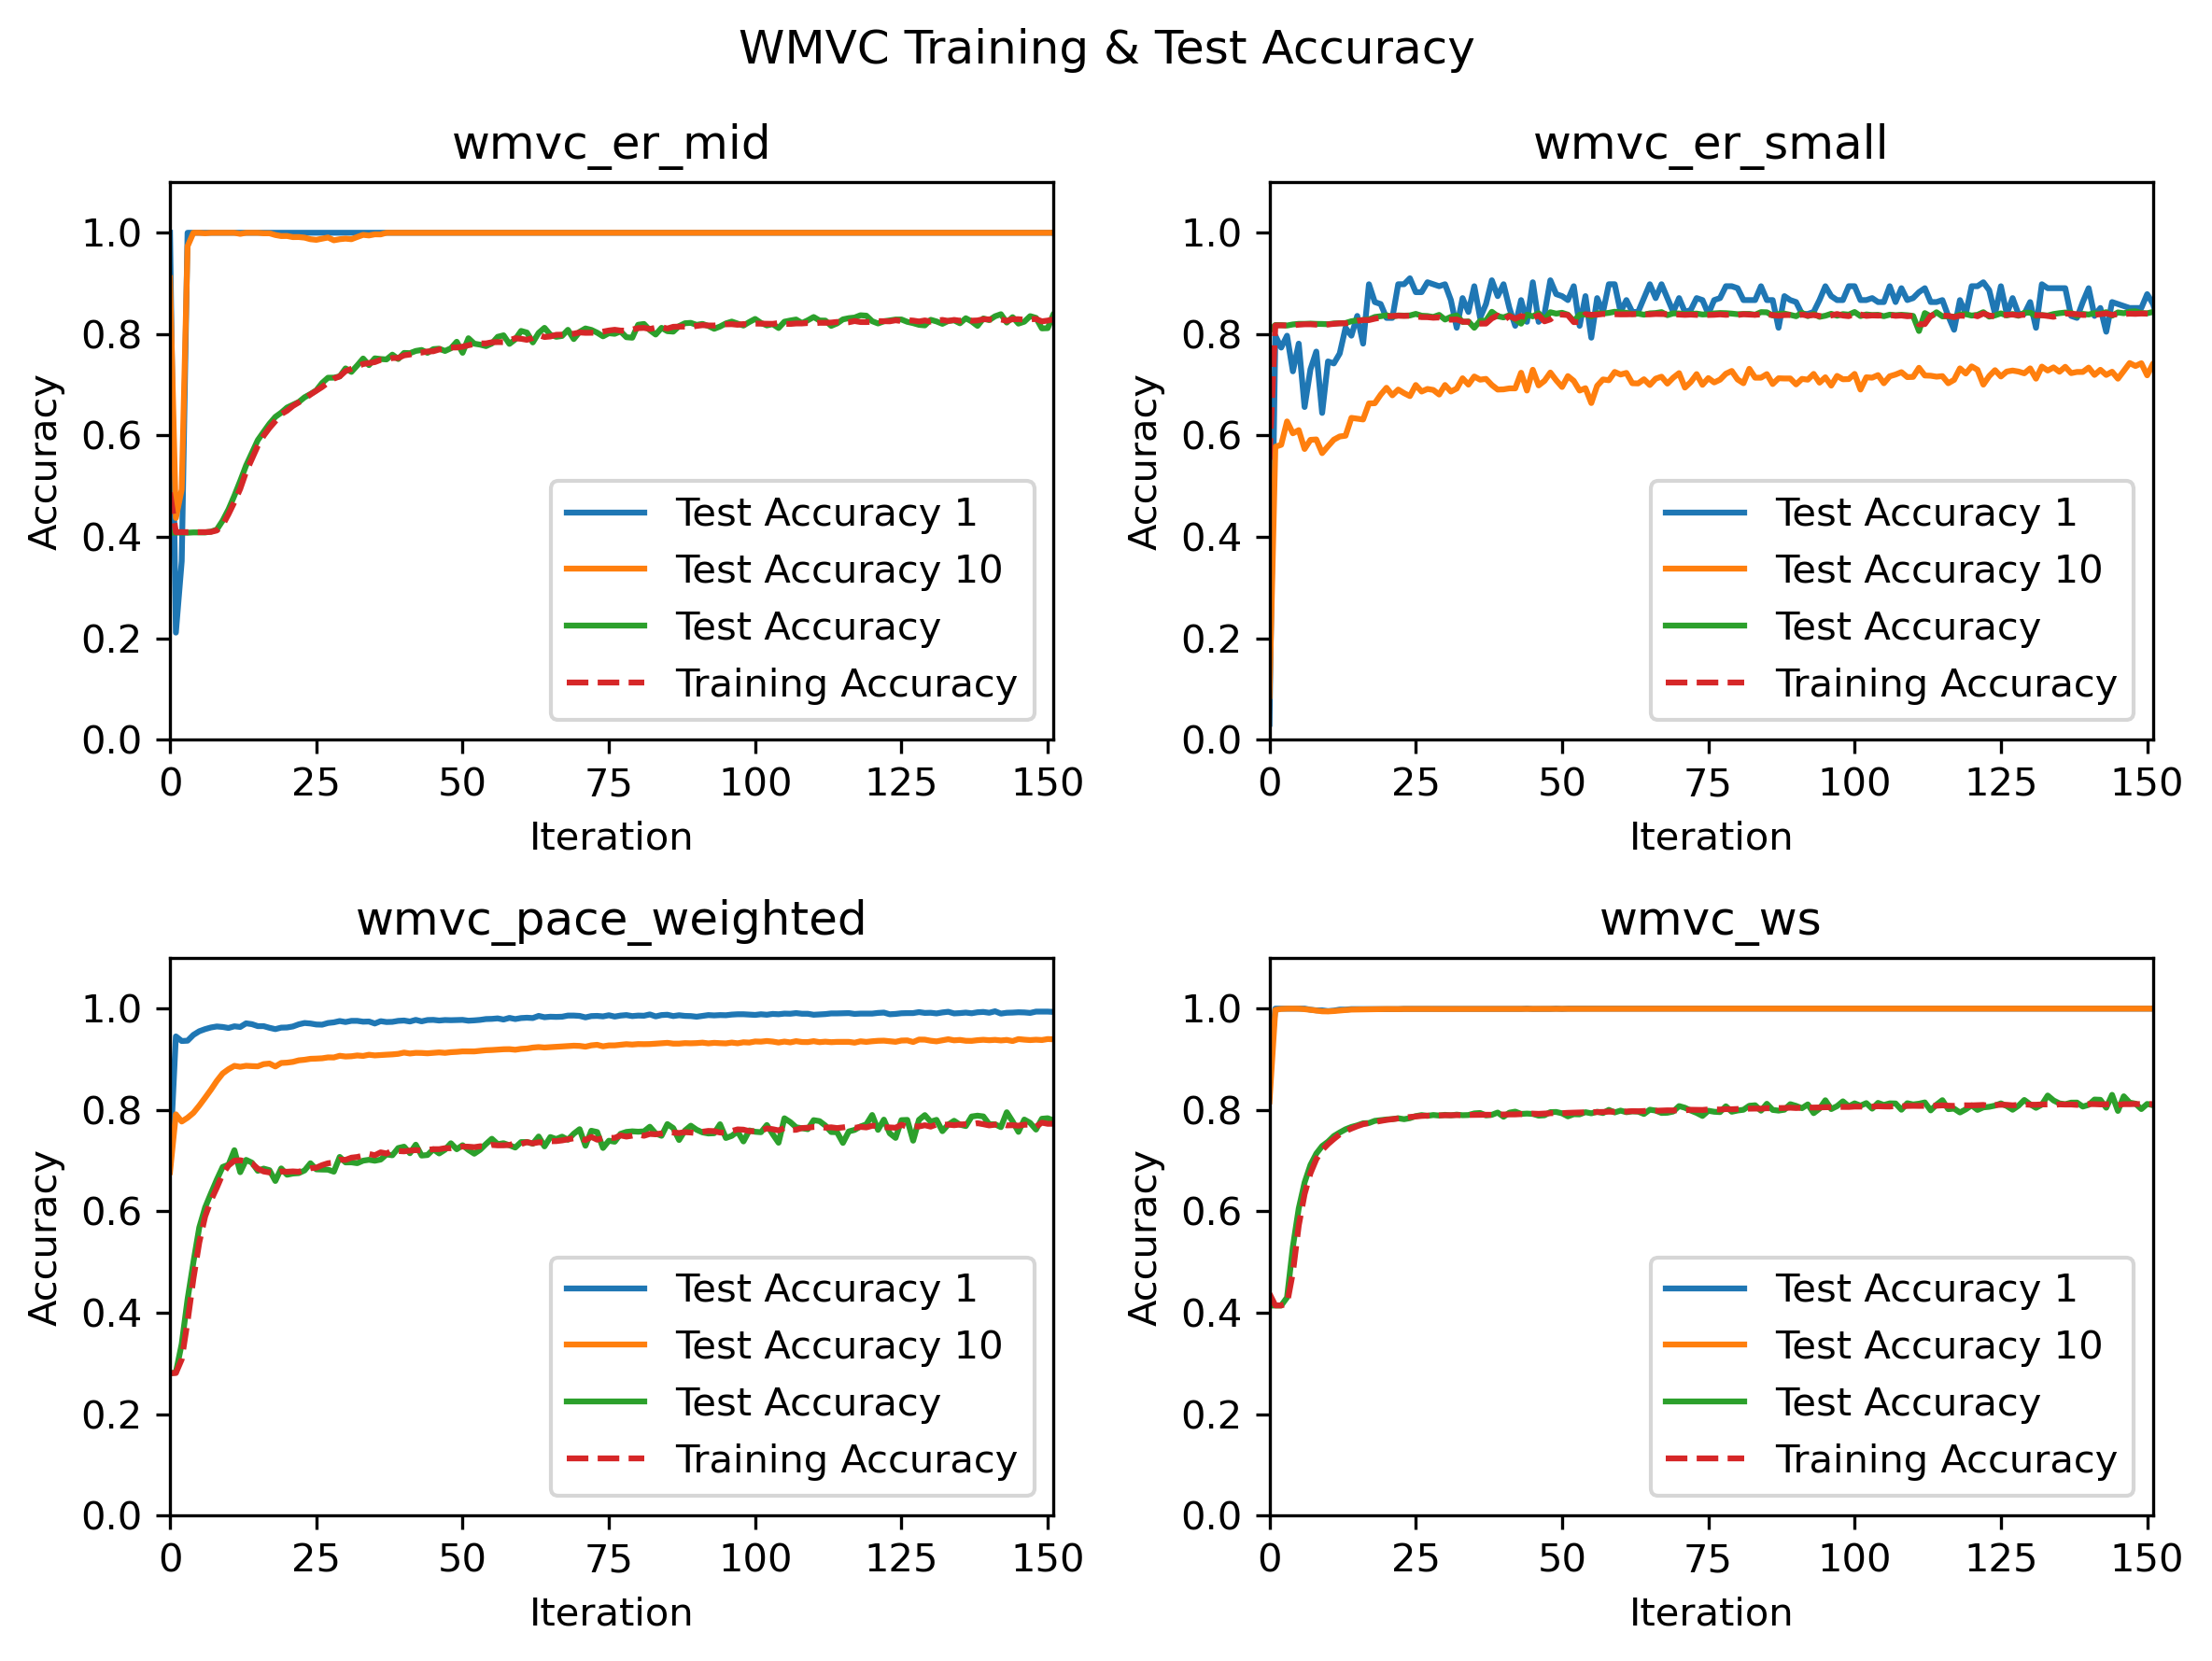

In [134]:
plot_training_all(wmvc_eval, "WMVC Training & Test Accuracy", "wmvc_test.pdf")

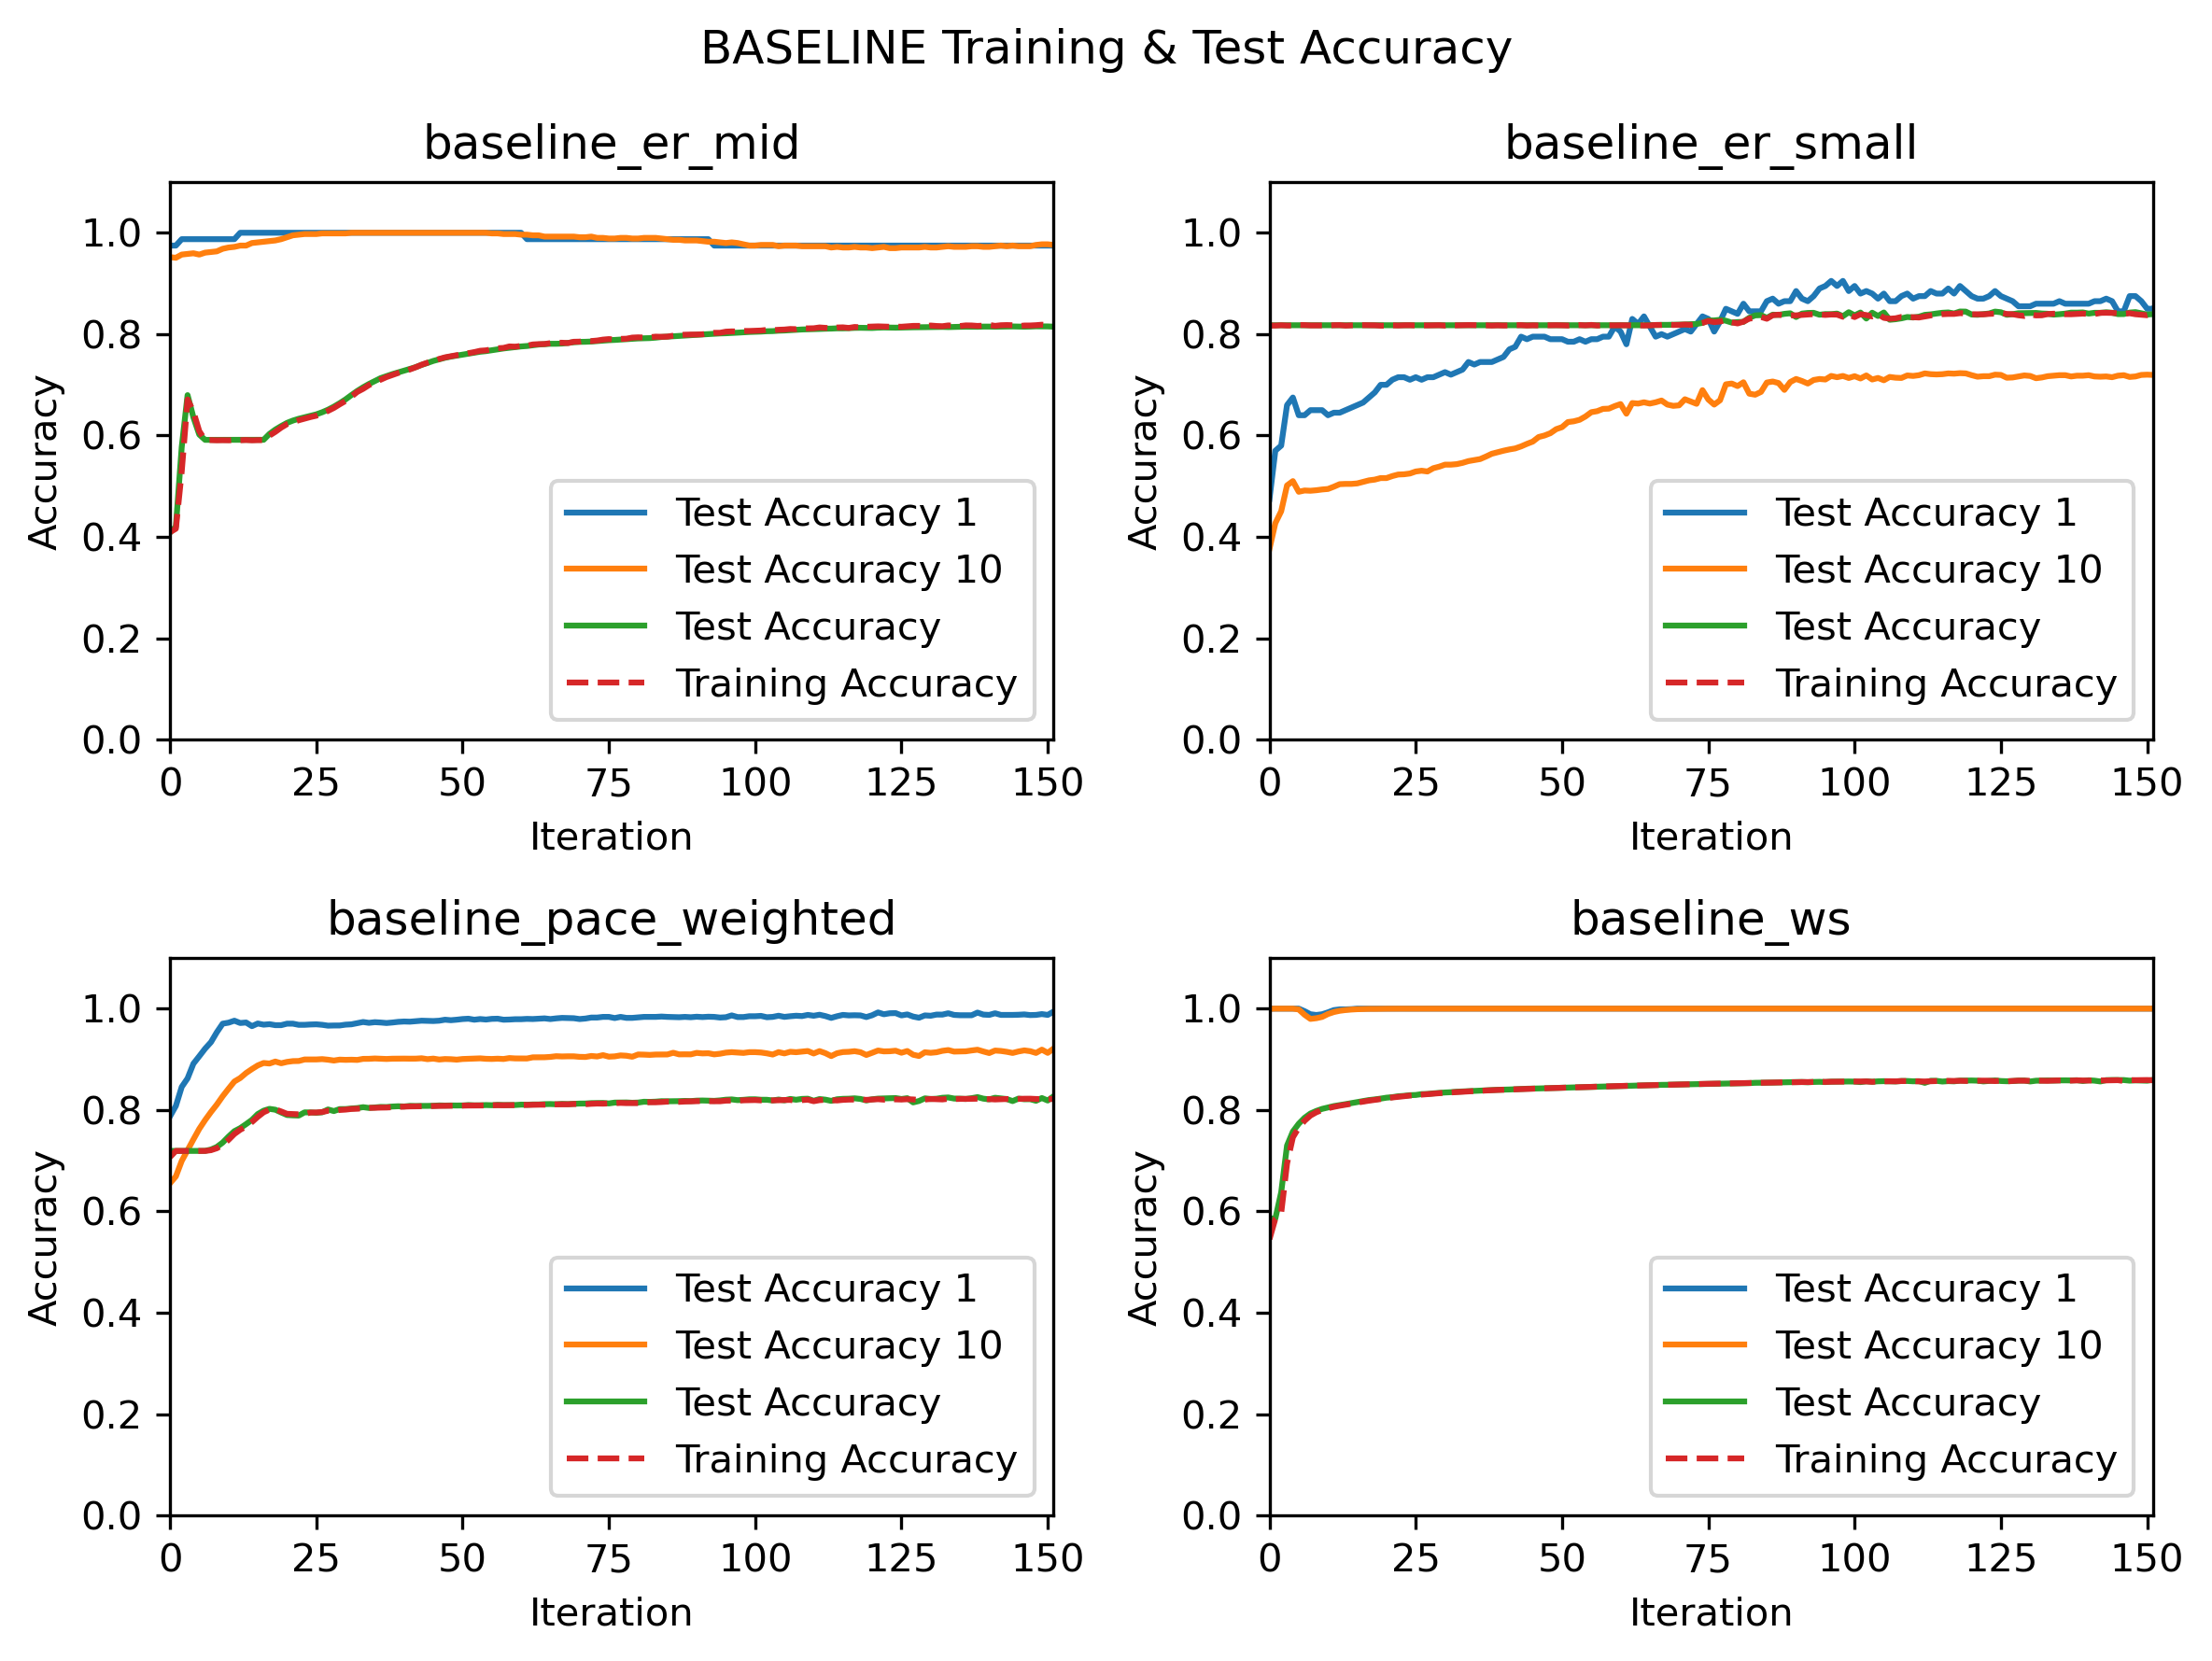

In [135]:
plot_training_all(
    baseline_eval, "BASELINE Training & Test Accuracy", "baseline_test.pdf"
)

In [138]:
for path in wmvc_eval:
    print(path.stem)
    print(pd.read_csv(path).max())
    print("-" * 100)

wmvc_er_mid
train_loss      0.687616
train_acc       0.835094
train_acc_10    1.000000
train_acc_1     1.000000
eval_acc        0.848085
eval_acc_10     1.000000
eval_acc_1      1.000000
dtype: float64
----------------------------------------------------------------------------------------------------
wmvc_er_small
train_loss      0.916957
train_acc       0.846683
train_acc_10    0.787740
train_acc_1     0.932692
eval_acc        0.858555
eval_acc_10     0.819531
eval_acc_1      0.945312
dtype: float64
----------------------------------------------------------------------------------------------------
wmvc_pace_weighted
train_loss      0.683685
train_acc       0.785903
train_acc_10    0.950547
train_acc_1     0.992188
eval_acc        0.813786
eval_acc_10     0.951275
eval_acc_1      0.996094
dtype: float64
----------------------------------------------------------------------------------------------------
wmvc_ws
train_loss      0.622601
train_acc       0.820076
train_acc_10    1.000000

In [139]:
for path in baseline_eval:
    print(path.stem)
    print(pd.read_csv(path).max())
    print("-" * 100)

baseline_er_mid
train_loss      0.708640
train_acc       0.835752
train_acc_10    1.000000
train_acc_1     1.000000
eval_acc        0.834316
eval_acc_10     1.000000
eval_acc_1      1.000000
dtype: float64
----------------------------------------------------------------------------------------------------
baseline_er_small
train_loss      0.594911
train_acc       0.842104
train_acc_10    0.730762
train_acc_1     0.896484
eval_acc        0.844600
eval_acc_10     0.725500
eval_acc_1      0.905000
dtype: float64
----------------------------------------------------------------------------------------------------
baseline_pace_weighted
train_loss      0.630665
train_acc       0.825148
train_acc_10    0.925484
train_acc_1     0.983323
eval_acc        0.832447
eval_acc_10     0.931226
eval_acc_1      0.995117
dtype: float64
----------------------------------------------------------------------------------------------------
baseline_ws
train_loss      0.684155
train_acc       0.861401
train_ac

In [149]:
import hiddenlayer as hl
from torchview import draw_graph
from torchviz import make_dot

transforms = [hl.transforms.Prune("Constant")]  # Removes Constant nodes from graph.

graph = hl.build_graph(model, batch.text, transforms=transforms)

In [175]:
%run ../wmis_gnn_py/arch/wmvc.py
%run ../wmis_gnn_py/arch/baseline.py
%run ../wmis_gnn_py/util/pyg_interface.py
%run ../wmis_gnn_py/util/metis.py

ModuleNotFoundError: No module named 'arch'

In [159]:
er_small_paths = list(yield_metis_filenames("../data/erdos_reyni_small/"))

In [161]:
tensor = nx_to_tensor(metis_to_nx(er_small_paths[0]))
tensor

Data(edge_index=[2, 4026], weight=[200], id=[200], x=[200, 7])

In [186]:
model = WMVC(7, 32, 2)
y = model(tensor.x, tensor.edge_index)
dot = make_dot(y, params=dict(model.named_parameters()))
dot.render("wmvc_arch")

'wmvc_arch.pdf'

In [188]:
model = Baseline(7, 32, 2)
y = model(tensor.x, tensor.edge_index)
dot = make_dot(y, params=dict(model.named_parameters()))
dot.render("baseline_arch")

'baseline_arch.pdf'

In [ ]:
%run ../wmis_gnn_py/util/metis.py

In [ ]:
??metis_to_nx

Signature: metis_to_nx(filename: str)
Docstring: <no docstring>
Source:   
def metis_to_nx(filename: str):
    G = nx.Graph()

    with open(filename, "r") as f:
        for line_num, line in enumerate(f):
            if line_num == 0:
                n_vertices, n_edges, graph_type = map(int, line.split(" "))

                assert n_vertices >= 0
                assert n_edges >= 0
                assert graph_type == 10

                continue

            if line[0] == "%":
                continue

            node_weight, *neighbors = map(int, line.split(" "))

            assert node_weight > 0

            G.add_node(line_num, weight=node_weight)

            for v in neighbors:
                assert 1 <= v <= n_vertices
                G.add_edge(line_num, v)

        assert G.size() == n_edges

    return G
File:      /gpfs/gibbs/project/karbasi/cz397/CPSC583-Project/wmis_gnn_py/util/metis.py
Type:      function


In [10]:
def summarize_graph(G: nx.Graph, name: str):
    n_nodes = G.order()
    n_edges = G.size()
    avg_deg = 2 * n_edges / n_nodes
    n_components = nx.number_connected_components(G)
    n_isolates = nx.number_of_isolates(G)
    sum_weights = sum(G.nodes[v]["weight"] for v in range(1, G.order() + 1))
    # transitivity = nx.transitivity(G)
    # degree_assortativity_coefficient = nx.degree_assortativity_coefficient(G)
    # estrada_index = nx.estrada_index(G)
    # treewidth_min_fill_in, _ = approximation.treewidth_min_fill_in(G)
    treewidth_min_degree, _ = approximation.treewidth_min_degree(G)
    # treewidth_approx = min(treewidth_min_fill_in, treewidth_min_degree)
    # s_metric = cugraph.s_metric(G, normalized=True)
    average_clustering = approximation.average_clustering(G)

    # is_chordal = nx.is_chordal(G)
    # is_planar = nx.is_planar(G)
    # is_eulerian = nx.is_eulerian(G)
    # is_regular = nx.is_regular(G)

    return {
        "name": name,
        "n_nodes": n_nodes,
        "n_edges": n_edges,
        "avg_deg": avg_deg,
        "n_components": n_components,
        "n_isolates": n_isolates,
        "sum_weights": sum_weights,
        # "transitivity": transitivity,
        # "degree_assortativity_coefficient": degree_assortativity_coefficient,
        # "estrada_index": estrada_index,
        "treewidth_min_degree": treewidth_min_degree,
        # "treewidth_approx": treewidth_approx,
        "average_clustering": average_clustering,
        # "s_metric": s_metric,
        # "is_planar": is_planar,
        # "is_chordal": is_chordal,
        # "is_eulerian": is_eulerian,
        # "is_regular": is_regular,
    }

# Small Erdos-Reyni Graphs

In [65]:
rows = []

ind_base = pathlib.Path("../data/erdos_reyni_small/label/")

graph_paths = np.random.choice(
    list(yield_metis_filenames("../data/erdos_reyni_small/")), 200, replace=False
)
ind_paths = set(path.stem for path in yield_solution_filenames(ind_base.resolve()))
for graph_path in tqdm(graph_paths):
    G = metis_to_nx(graph_path.resolve())
    summary_dict = summarize_graph(G, graph_path.stem)
    summary_dict["kamis_weight"] = -np.inf

    if graph_path.stem in ind_paths:
        ind_path = ind_base / graph_path.with_suffix(".ind").name
        solution_to_nx(G, ind_path.resolve())
        solution_weight = sum(
            G.nodes[v]["weight"]
            for v in range(1, G.order() + 1)
            if G.nodes[v]["solution"] == 1
        )
        summary_dict["kamis_weight"] = solution_weight

    rows.append(pd.Series(summary_dict))

    gc.collect()

df_er = pd.DataFrame(rows).set_index("name")
df_er

100%|██████████| 200/200 [03:15<00:00,  1.02it/s]


,n_nodes,n_edges,avg_deg,n_components,n_isolates,sum_weights,treewidth_min_degree,average_clustering,kamis_weight
name,,,,,,,,,
erdos-reyni-n200-p0.1--maxw400-seed20_681,200,1983,19.83,1,0,40965,134,0.093,10582
erdos-reyni-n200-p0.1--maxw400-seed20_259,200,2076,20.76,1,0,40134,137,0.112,9574
erdos-reyni-n200-p0.1--maxw400-seed20_535,200,2029,20.29,1,0,41677,136,0.108,10665
erdos-reyni-n200-p0.1--maxw400-seed20_764,200,2038,20.38,1,0,41382,136,0.099,10276
erdos-reyni-n200-p0.1--maxw400-seed20_332,200,1975,19.75,1,0,38274,133,0.098,10204
...,...,...,...,...,...,...,...,...,...
erdos-reyni-n200-p0.1--maxw400-seed20_171,200,2046,20.46,1,0,39624,135,0.102,10387
erdos-reyni-n200-p0.1--maxw400-seed20_513,200,1969,19.69,1,0,41324,135,0.085,10323
erdos-reyni-n200-p0.1--maxw400-seed20_379,200,2033,20.33,1,0,40261,138,0.082,9884


In [66]:
df_er.to_csv("erdos_reyni_small.csv")

In [2]:
def plot_graph_df(df):
    fig, axes = plt.subplots(3, 2, figsize=(12, 12), dpi=200)
    # fig.suptitle("PACE Graph Statistics", fontsize="xx-large")
    fig.tight_layout(h_pad=5, w_pad=0)

    axes[0, 0].ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
    axes[0, 0].set_xlabel("Number of Vertices", fontsize="large")
    axes[0, 0].set_title("Histogram of Number of Vertices", fontsize="x-large")
    df.n_nodes.hist(bins=50, log=True, ax=axes[0, 0])

    axes[0, 1].ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
    axes[0, 1].set_xlabel("Number of Edges", fontsize="large")
    axes[0, 1].set_title("Histogram of Number of Edges", fontsize="x-large")
    df.n_edges.hist(bins=50, log=True, ax=axes[0, 1])

    # axes[0, 2].ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
    axes[1, 0].set_xlabel("Average Degree", fontsize="large")
    axes[1, 0].set_title("Histogram of Average Degree", fontsize="x-large")
    df.avg_deg.hist(bins=50, log=True, ax=axes[1, 0])

    axes[1, 1].ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
    axes[1, 1].set_xlabel("Number of Connected Components", fontsize="large")
    axes[1, 1].set_title(
        "Histogram of Number of Connected Components", fontsize="x-large"
    )
    df.n_components.hist(bins=50, log=True, ax=axes[1, 1])

    # axes[1, 1].ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
    axes[2, 0].set_xlabel("Treewidth Upperbound", fontsize="large")
    axes[2, 0].set_title("Histogram of Treewidth Upperbound", fontsize="x-large")
    df.treewidth_min_degree.hist(bins=50, log=True, ax=axes[2, 0])

    # axes[1, 2].ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
    axes[2, 1].set_xlabel(
        "Approximate Average Clustering Coefficient", fontsize="large"
    )
    axes[2, 1].set_title(
        "Histogram of Approximate Average Clustering Coefficient", fontsize="x-large"
    )
    df.average_clustering.hist(bins=50, log=True, ax=axes[2, 1])

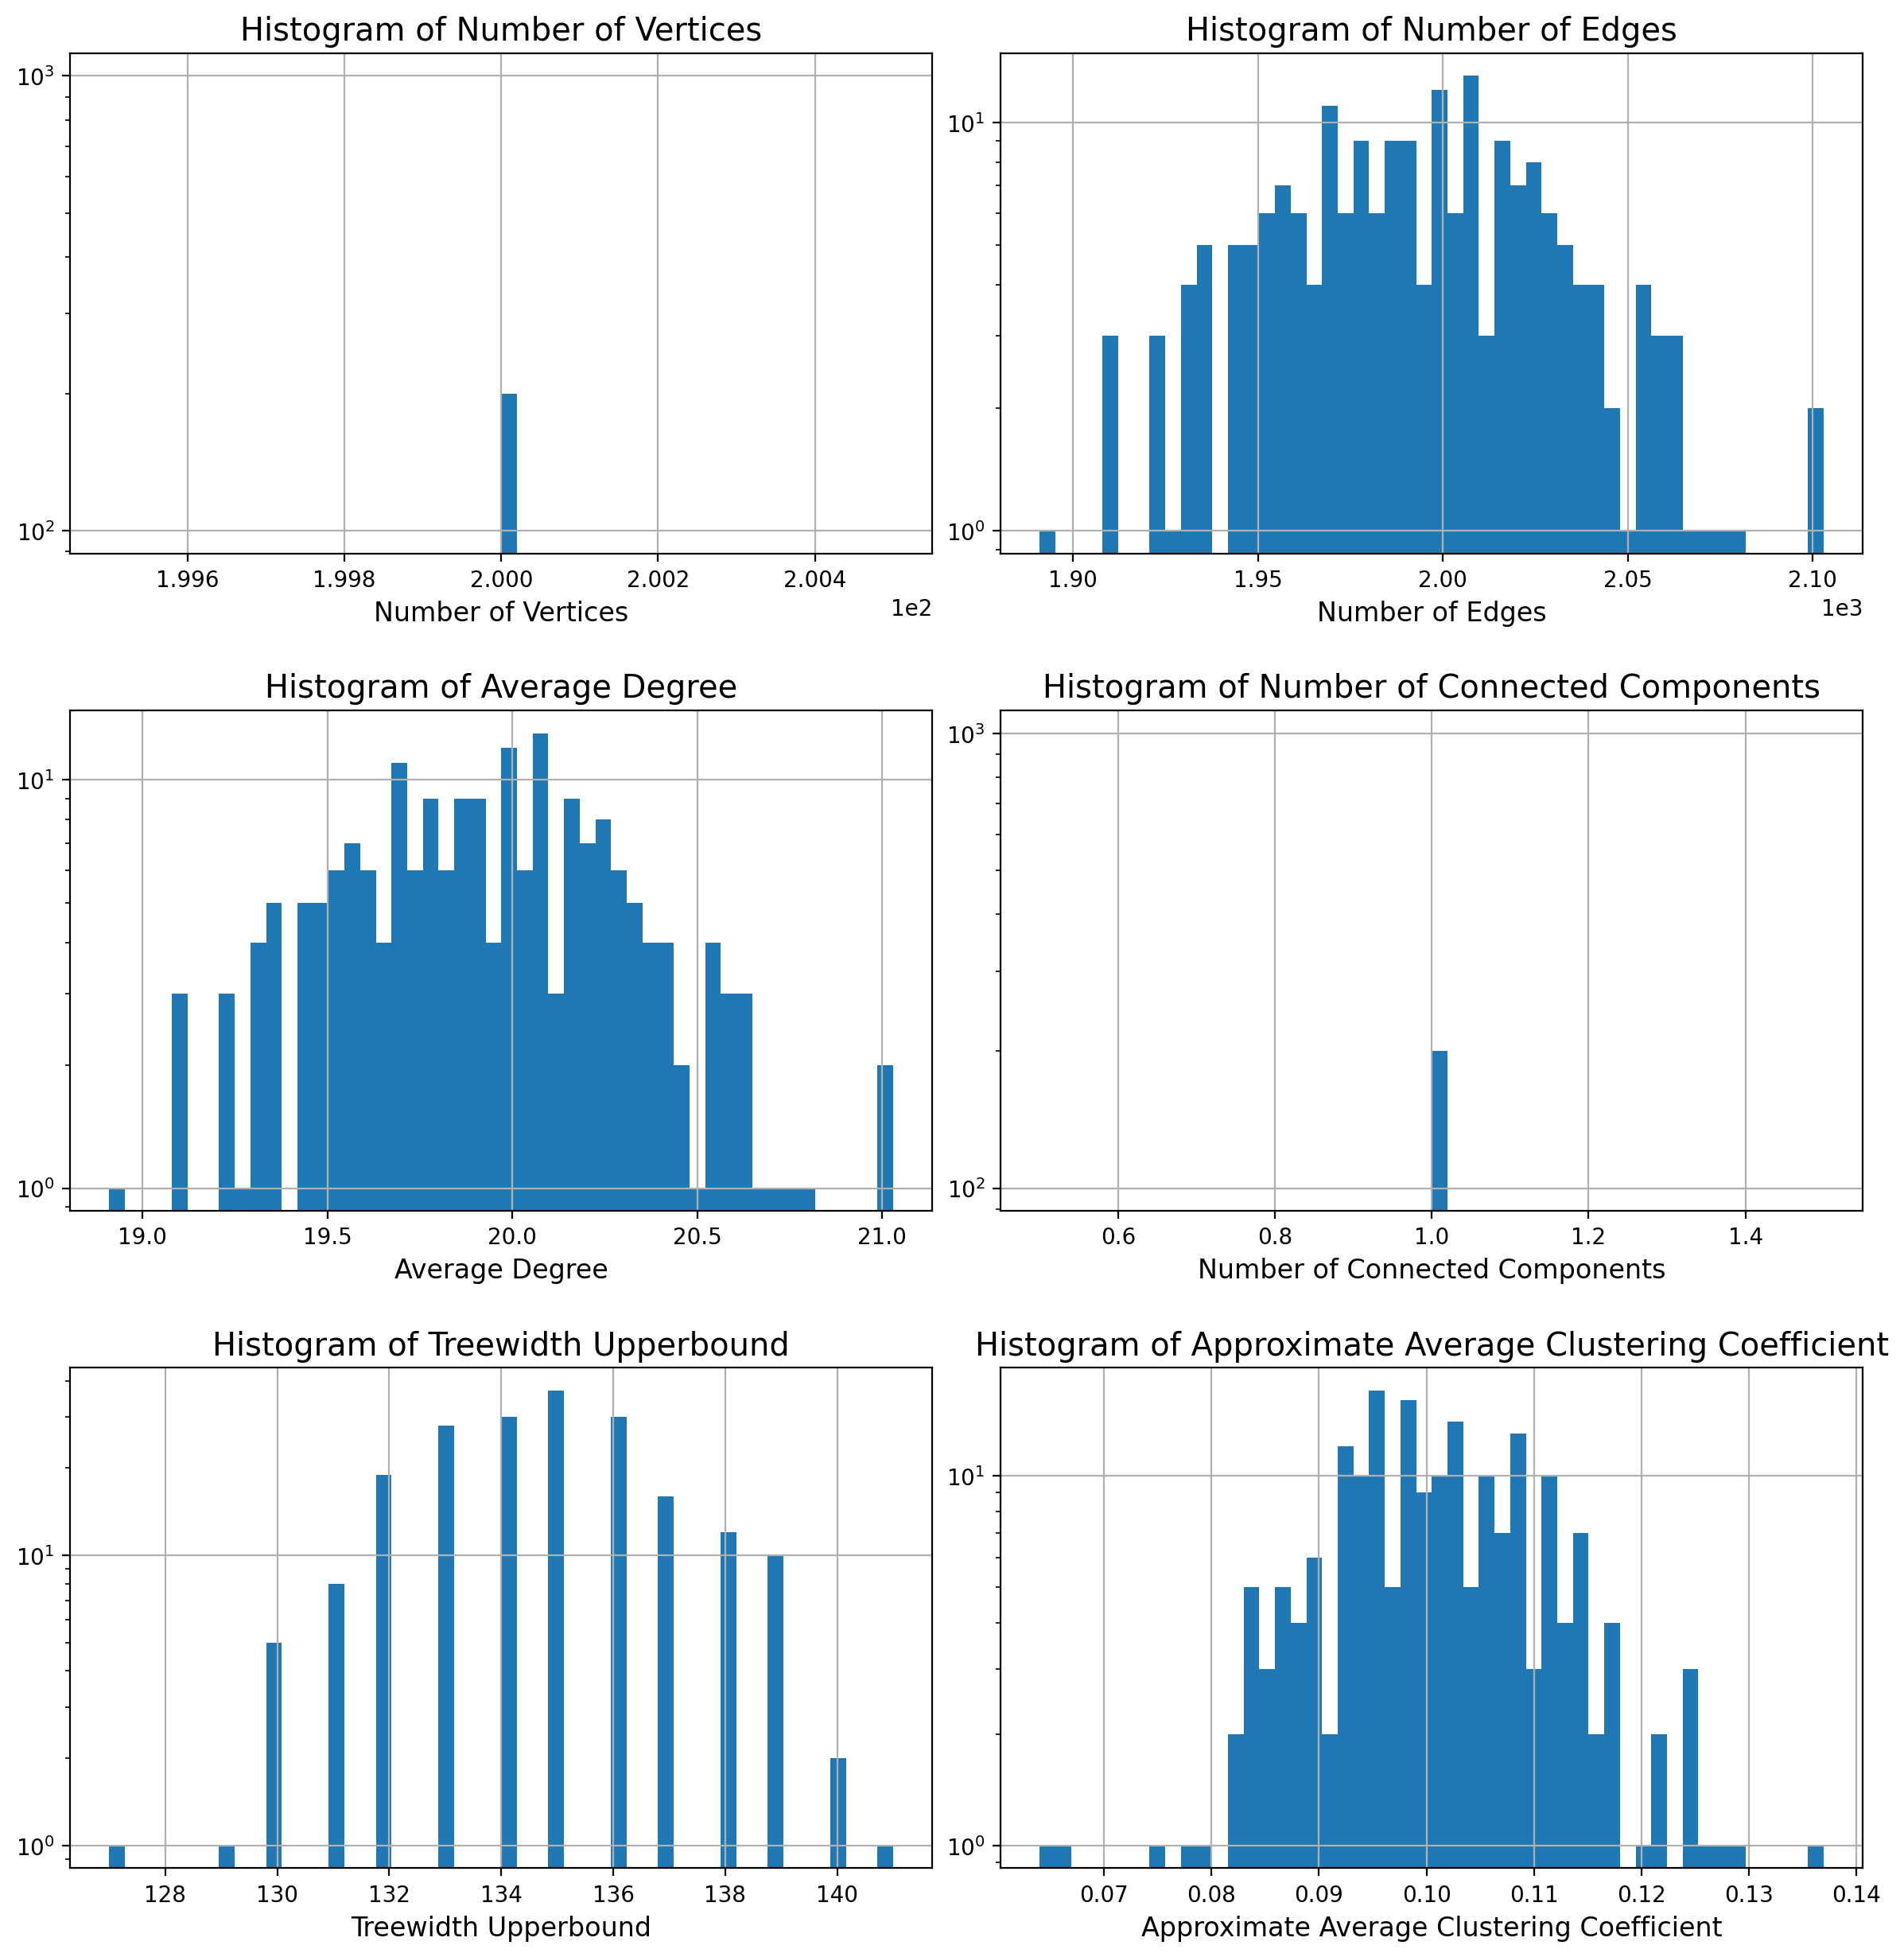

In [3]:
df_er = pd.read_csv("erdos_reyni_small.csv")

plot_graph_df(df_er)
plt.savefig("erdos_reyni_small.pdf", bbox_inches="tight")

# PACE 2019 Competition Graphs

In [11]:
rows = []

filepaths = list(yield_metis_filenames("../data/pace_unweighted/"))
# print(filepaths)
for filepath in tqdm(filepaths):
    path = filepath.resolve()
    # print(path)
    G = metis_to_nx(path)
    rows.append(pd.Series(summarize_graph(G, path.stem)))

    gc.collect()

df_pace = pd.DataFrame(rows).set_index("name")
df_pace

100%|██████████| 200/200 [54:53<00:00, 16.47s/it]   


,n_nodes,n_edges,avg_deg,n_components,n_isolates,sum_weights,treewidth_min_degree,average_clustering
name,,,,,,,,
vc-exact_001,6160,40207,13.054221,32,0,6160,131,0.697
vc-exact_002,51795,41253,1.592934,10542,0,51795,1,0.000
vc-exact_003,60541,48418,1.599511,12123,0,60541,1,0.000
vc-exact_004,8114,26013,6.411881,6,0,8114,1612,0.013
vc-exact_005,200,798,7.980000,1,0,200,85,0.051
...,...,...,...,...,...,...,...,...
vc-exact_196,1534,126082,164.383312,1,0,1534,1342,0.221
vc-exact_197,1534,127011,165.594524,1,0,1534,1336,0.207
vc-exact_198,1150,80072,139.255652,1,0,1150,1008,0.226


In [12]:
df_pace.to_csv("pace_unweighted.csv")

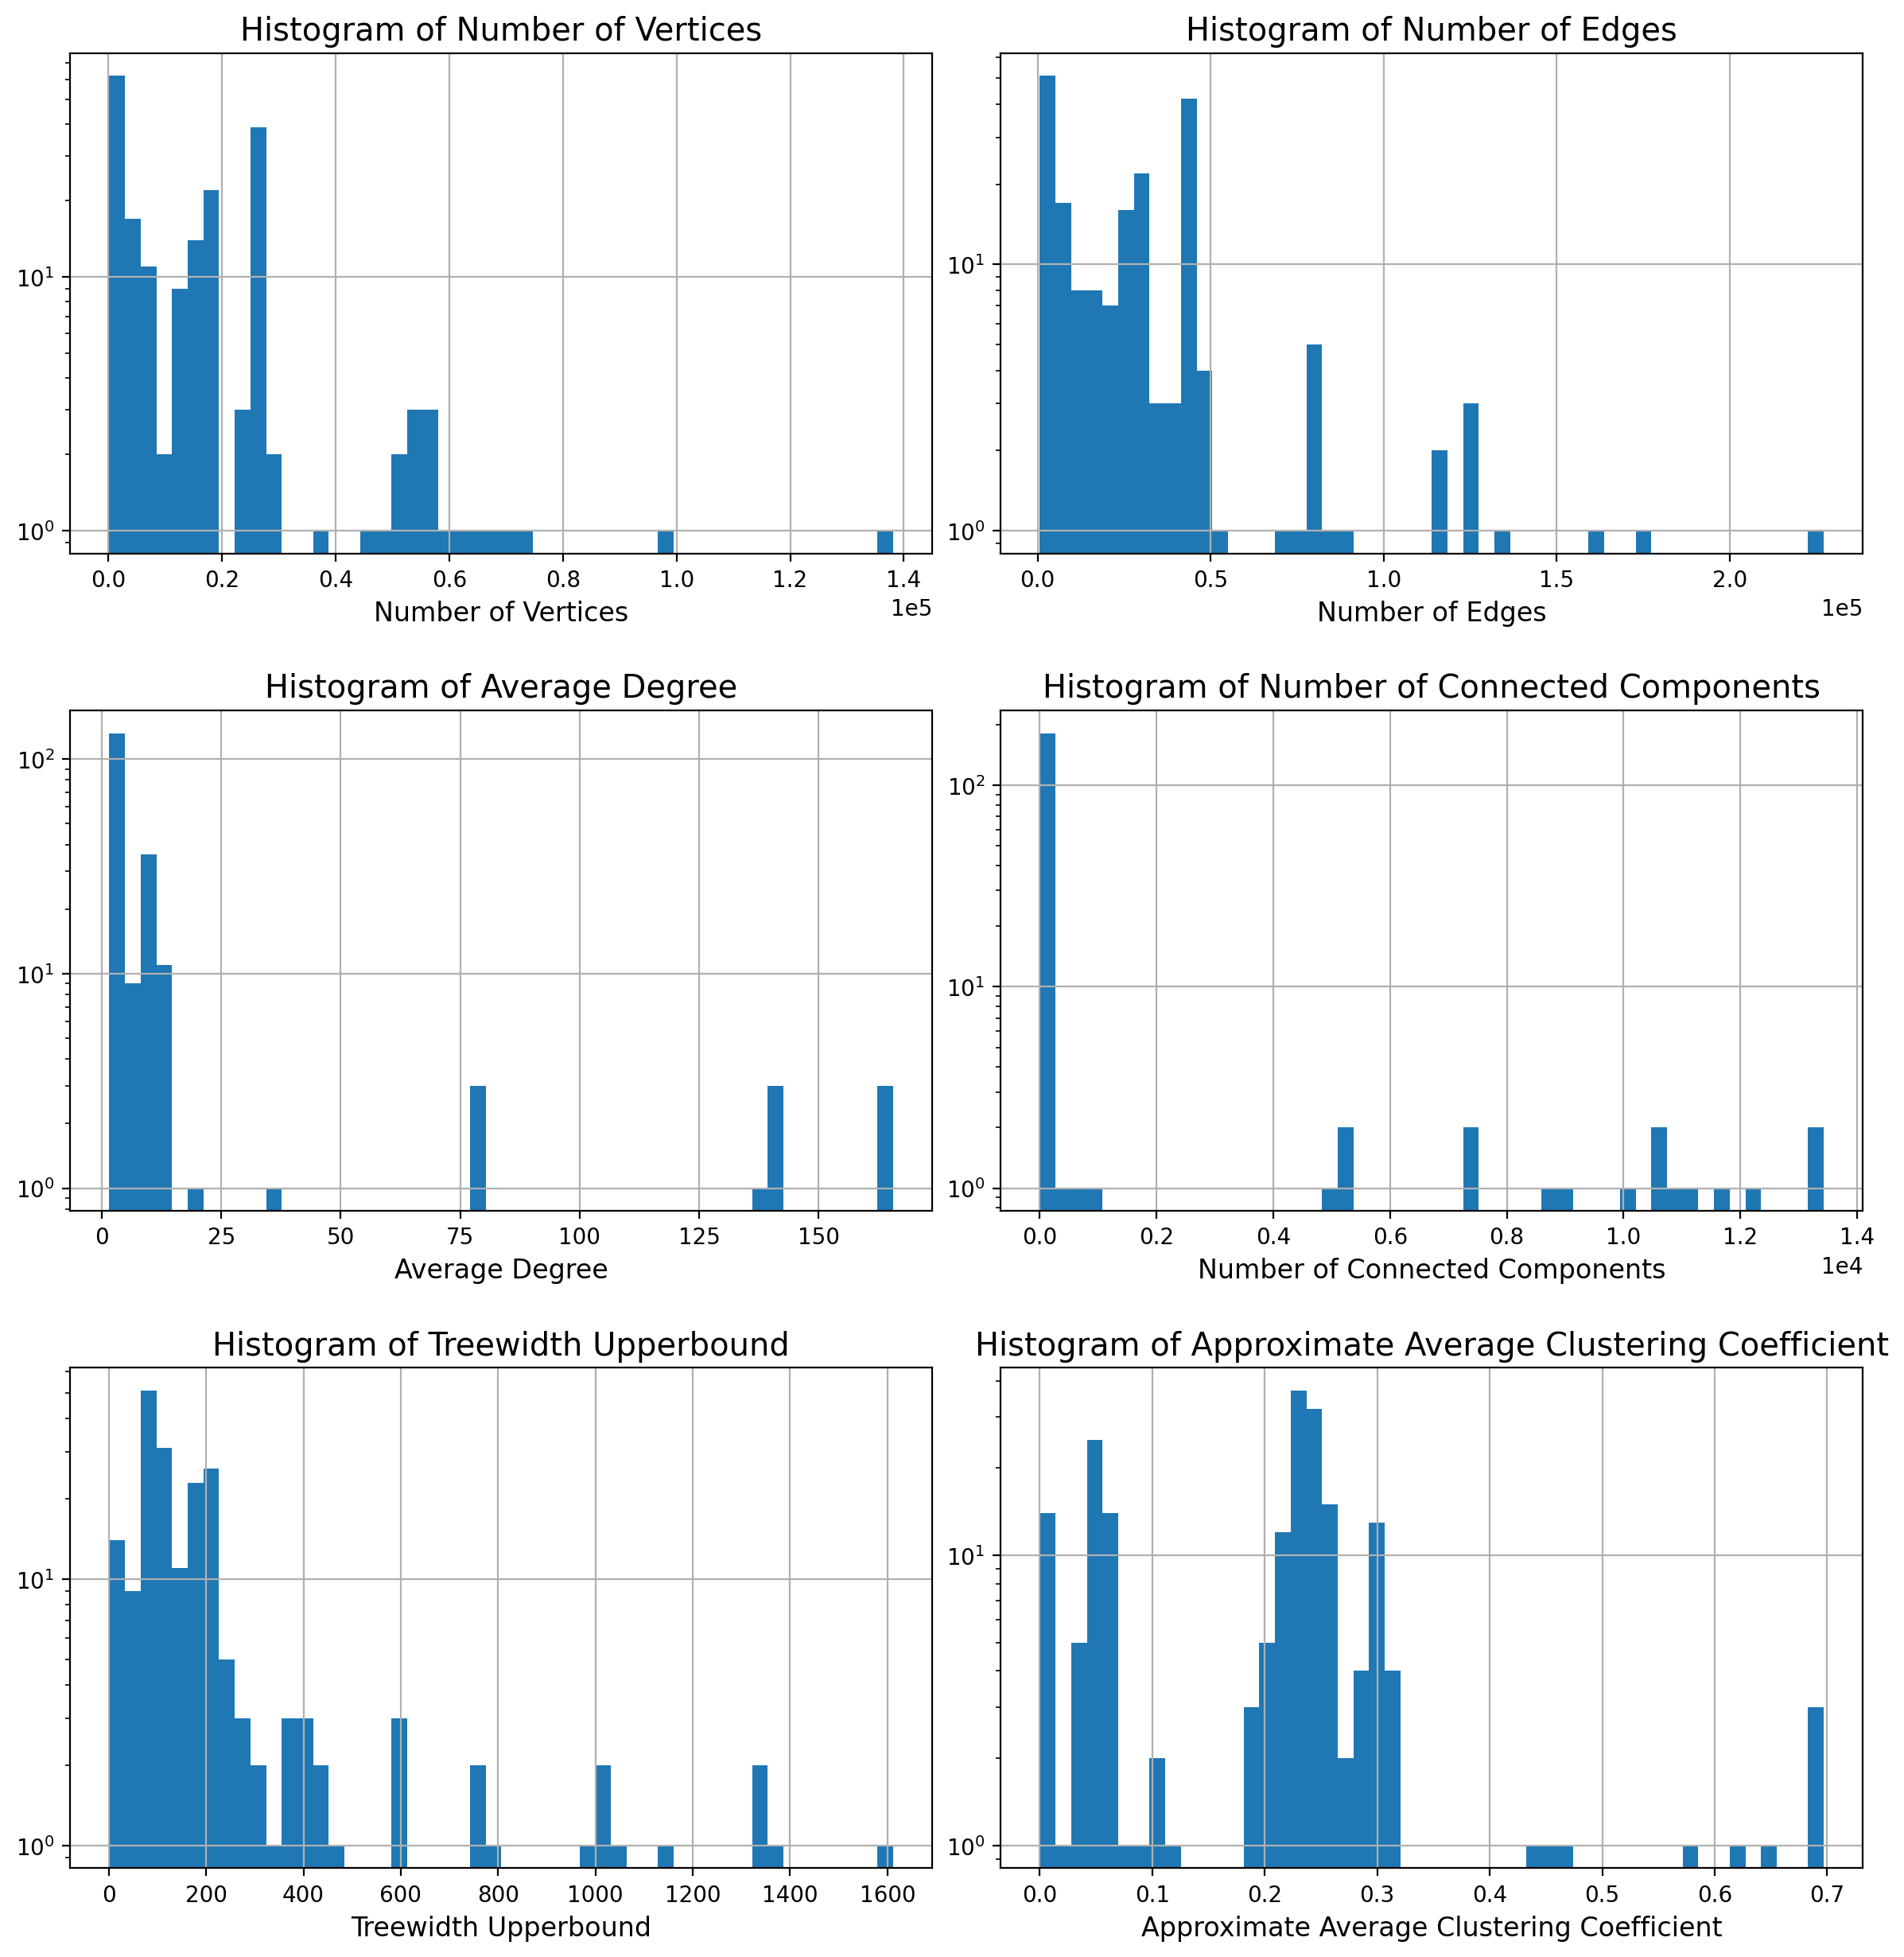

In [4]:
df_pace = pd.read_csv("pace_unweighted.csv")

plot_graph_df(df_pace)
plt.savefig("pace_unweighted.pdf", bbox_inches="tight")